In [33]:
# Download data
!git clone https://github.com/CSSEGISandData/COVID-19.git

# Install 'geocoder'
!pip install geocoder

# Importing modules
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime 
import geocoder
import folium
from folium import plugins 

# DataFrame for the world
conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
conf_df = pd.read_csv(conf_csv)
grouped_conf_df = conf_df.groupby(by = ['Country/Region'], as_index = False).sum()

# DataFrame for India
india_df = pd.read_csv("https://api.covid19india.org/csv/latest/state_wise.csv")
india_df = india_df.iloc[1:36, :]
state_latitudes = []
state_longitudes = []
for i in india_df.index:
    state = india_df['State'][i]
    state_lat = geocoder.osm(state).lat
    state_lng = geocoder.osm(state).lng
    state_latitudes.append(state_lat)
    state_longitudes.append(state_lng)

state_latitudes = pd.Series(data = state_latitudes, index = india_df.index)
state_longitudes = pd.Series(data = state_longitudes, index = india_df.index)
india_df['Latitude'] = state_latitudes
india_df['Longitude'] = state_longitudes

# DataFrame for the US
us_conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_conf_df = pd.read_csv(us_conf_csv)
us_conf_df = us_conf_df.dropna()
grouped_us_conf_df = us_conf_df.groupby(by = ['Combined_Key'], as_index = False).sum()

# Function to get total confirmed cases in a country
def get_total_confirmed_cases_for_country(country_name):
    total_cases_country = conf_df[conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_cases_country.index = pd.to_datetime(total_cases_country.index)
    return total_cases_country

# Function to get total confirmed cases in the world
def get_total_confirmed_global_cases():
    global_cases = conf_df.iloc[:, 4:].apply(sum, axis=0)
    global_cases.index = pd.to_datetime(global_cases.index)
    return global_cases

# Function to create a line plot
def line_plot(plot_background, fig_width, fig_height, country_name, colour, linewidth, markertype):
    dt_series = None
    if country_name != 'global':
        dt_series = get_total_confirmed_cases_for_country(country_name)
    else:
        dt_series = get_total_confirmed_global_cases()
    plt.style.use(plot_background)
    plt.figure(figsize = (fig_width, fig_height))
    plt.title(f'{country_name.upper()}: Total Coronavirus Cases Reported', fontsize = 16)
    plt.plot(dt_series.index, dt_series, c = colour, lw = linewidth, marker = markertype, markersize = 7)
    plt.xticks(rotation = 45)
    plt.ylabel("Total Cases")
    plt.grid(linestyle='--', c='grey')
    plt.show()

# Add minimap
def add_minimap(map_name):
    # Plugin for mini map
    minimap = plugins.MiniMap(toggle_display = True)
    map_name.add_child(minimap) # Add minimap
    plugins.ScrollZoomToggler().add_to(map_name) # Add scroll zoom toggler to map
    plugins.Fullscreen(position='topright').add_to(map_name) # Add full screen button to map

# Add title to map
def add_title(map_name, country):
    title_html = '''
        <h2 align="center" style="font-size:20px"><b>Coronavirus Total Confirmed Cases in {}</b></h2>
             '''.format(country)   
    return map_name.get_root().html.add_child(folium.Element(title_html))

# Function to create folium maps using for India, US and the world
def folium_map_with_circles(country, map_width, map_height, left_margin, top_margin, map_tile, zoom, circle_color, minimap):
    last_col = conf_df.columns[-1]
    if country == 'India':
        india_map = folium.Map(location = [22.3511148, 78.6677428], 
                               width = map_width, height = map_height,
                               left = f"{left_margin}%", top = f"{top_margin}%",
                               tiles = map_tile, zoom_start = zoom)
        
        if minimap == True:
            add_minimap(india_map)
    
        add_title(india_map, country)    
        for i in india_df.index:
            folium.Circle(radius = float(india_df.loc[i, 'Confirmed']) / 3,
                          location = [india_df.loc[i, 'Latitude'], india_df.loc[i, 'Longitude']],
                          popup = "{}\n {}\n on {}".format(india_df.loc[i, 'State'], 
                                                          india_df.loc[i, 'Confirmed'], 
                                                          india_df.loc[i, 'Last_Updated_Time']),
                          
                          color = circle_color,
                          fill = True).add_to(india_map)
        return india_map

    elif country == 'World':
        world_map = folium.Map(location = [0, 0], 
                            width = map_width, height = map_height, 
                            left = f"{left_margin}%", top = f"{top_margin}%",
                            tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(world_map)
        
        add_title(world_map, country, your_name)
        for i in grouped_conf_df.index:
            folium.Circle(location = [grouped_conf_df.loc[i, 'Lat'], grouped_conf_df.loc[i, 'Long']], 
                          radius = int(grouped_conf_df.loc[i, last_col]) / 2, 
                          popup = "{}\n {}\n on {}".format(grouped_conf_df.loc[i, 'Country/Region'],
                                                          grouped_conf_df.loc[i, last_col], 
                                                          last_col),
                          color = circle_color, 
                          fill = True).add_to(world_map)
        return world_map
    else:
        print("\nWrong input! Enter either India, US or World.\n")

# Line plot for the daily (non-cumulative) confirmed cases in various countries.
def daily_cases_line_plot(num_countries, width, height):
    plt.figure(figsize=(width, height))
    plt.title(f'Non-Cumulative COVID-19 Confirmed Cases', fontsize = 16)
    for region in non_cum_conf_df.iloc[:num_countries, :]['Country/Region']:
        total_conf_cases = get_total_daily_confirmed_cases_for_country(region)
        plt.plot(total_conf_cases.index[53:], total_conf_cases[53:], lw=2.5, label=region)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid('major', linestyle='--', c='grey')
    plt.show()

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [34]:
conf_df[conf_df['Country/Region'] == 'India']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21
146,NaN,India,20.593684,78.96288,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,11285561,11308846,11333728,11359048,11385339,11409831,11438734,11474605,11514331,11555284,11599130,11646081,11686796,11734058,11787534,11846652,11908910,11971624,12039644,12095855,12149335,12221665,12303131,12392260,12485509,12589067,12686049,12801785,12928574,13060542,13205926,13358805,13527717,13689453,13873825,14074564,14291917,14526609,14788003,15061805


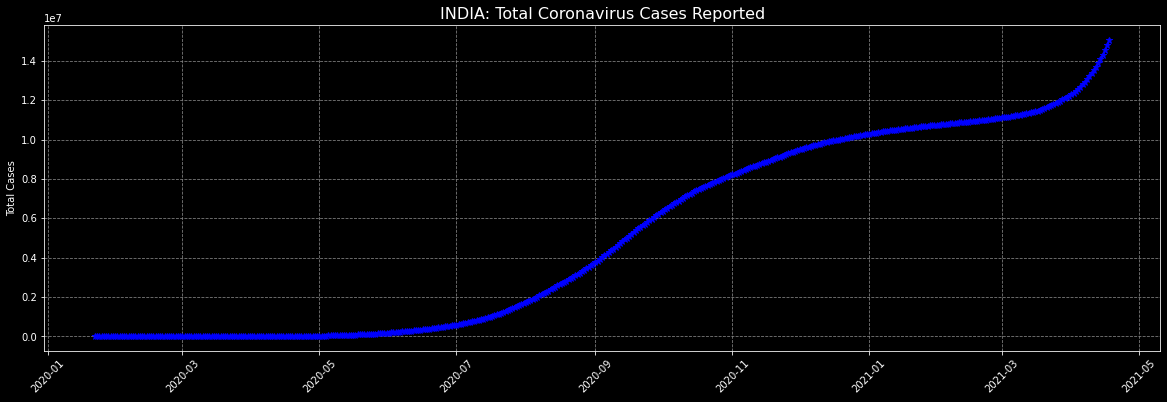

In [35]:
line_plot('dark_background', 20, 6, 'India', 'blue', 2, '*')

In [36]:
india_df.head()

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time,Migrated_Other,State_code,Delta_Confirmed,Delta_Recovered,Delta_Deaths,State_Notes,Latitude,Longitude
1,Maharashtra,3898262,3159240,60824,676520,19/04/2021 20:11:58,1678,MH,58924,52412,351,"[Dec 16]:10,218 duplicate cases & other state ...",18.906836,75.674158
2,Kerala,1253069,1144791,4951,103001,19/04/2021 19:02:13,326,KL,13644,4305,21,Mahe native who expired in Kannur included in ...,10.352874,76.512040
3,Karnataka,1176850,1021250,13497,142084,19/04/2021 20:12:00,19,KA,15785,7098,146,NaN,14.520390,75.722352
4,Andhra Pradesh,968000,912510,7437,48053,19/04/2021 18:21:06,0,AP,5963,2569,27,NaN,15.924091,80.186381
5,Tamil Nadu,1002392,914119,13157,75116,19/04/2021 19:32:04,0,TN,10941,6172,44,[July 22]: 444 backdated deceased entries adde...,10.909433,78.366535


In [37]:
folium_map_with_circles('India', 800, 500, 18, 2, 'Stamen Terrain', 4, 'red', True)

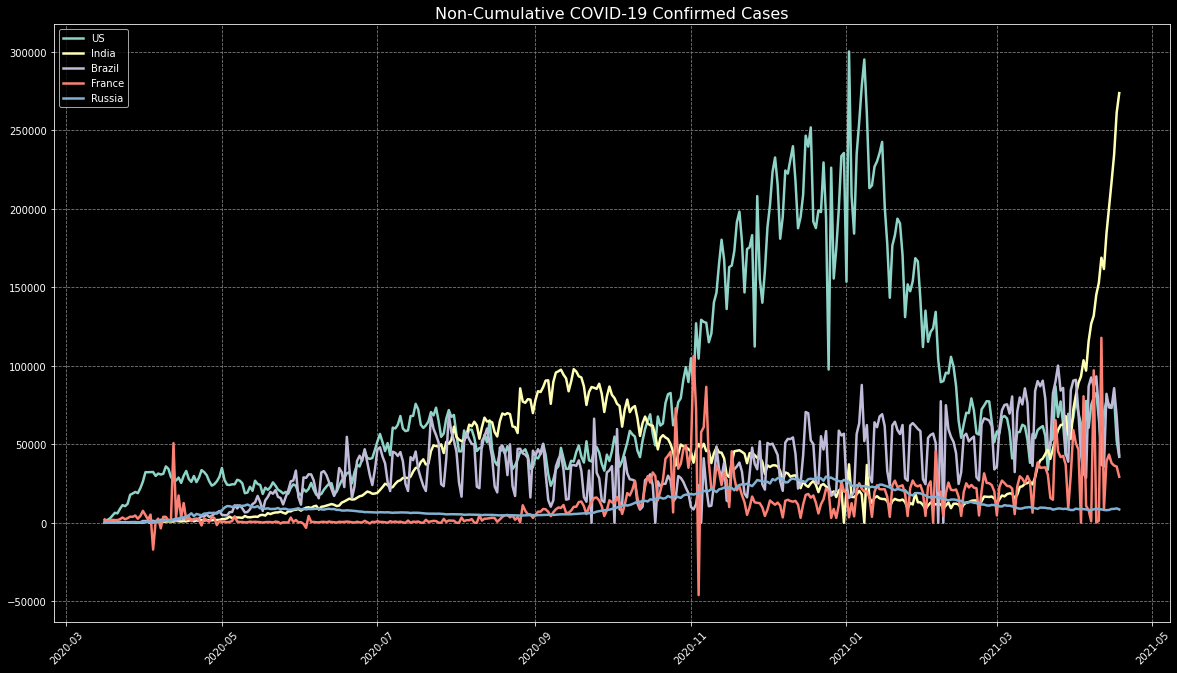

In [38]:
daily_cases_line_plot(5, 20, 11)